# Theory of variational quantum simulation

Paper by: Xiao Yuan, Suguru Endo, Qi Zhao, Ying Li, and Simon C. Benjamin (2019)

Link to paper: https://quantum-journal.org/papers/q-2019-10-07-191/

Notebook by: [Óscar Amaro](https://github.com/OsAmaro) 2024

See [Qiskit-Algorithms tutorial 11](https://github.com/qiskit-community/qiskit-algorithms/blob/main/docs/tutorials/11_VarQTE.ipynb)

_Summary:_ 

A 2 qubit system evolving according to the variational real time algorithm.

Equations 9 + 10:

$$
\begin{gathered}
\sum_j A_{i, j} \dot{\theta}_j=-i ~C_i \\
A_{i, j}=\frac{\partial\langle\phi(\vec{\theta}(t))|}{\partial \theta_i} \frac{\partial|\phi(\vec{\theta}(t))\rangle}{\partial \theta_j} \\
C_i=\frac{\partial\langle\phi(\vec{\theta}(t))|}{\partial \theta_i} H|\phi(\vec{\theta}(t))\rangle
\end{gathered}
$$


Equation 12 (assuming $\theta$ to be real):
$$
\sum_j A_{i, j}^R ~\dot{\theta}_j = C_i^I
$$

Equation 35 (mixed states):
$$
\begin{aligned}
M_{i, j} & =A_{i, j}^R+\frac{\partial\langle\phi(\vec{\theta}(t))|}{\partial \theta_i}|\phi(\vec{\theta}(t))\rangle \frac{\partial\langle\phi(\vec{\theta}(t))|}{\partial \theta_j}|\phi(\vec{\theta}(t))\rangle, \\
V_i & =C_i^I+i \frac{\partial\langle\phi(\vec{\theta}(t))|}{\partial \theta_i}|\phi(\vec{\theta}(t))\rangle\langle\phi(\vec{\theta}(t))| H|\phi(\vec{\theta}(t))\rangle .
\end{aligned}
$$

In [1]:
import numpy as np
from numpy import log, log10, sin, cos, exp, sqrt, pi
import pandas as pd
import glob as glob
import matplotlib.pyplot as plt
import json

from qiskit.circuit.library import EfficientSU2
from qiskit_algorithms.time_evolvers.variational import RealMcLachlanPrinciple, ImaginaryMcLachlanPrinciple
from qiskit_algorithms import TimeEvolutionProblem, VarQITE, VarQRTE, SciPyImaginaryEvolver, SciPyRealEvolver
from qiskit.primitives import Estimator
from qiskit.quantum_info import Statevector, SparsePauliOp

### Figure 2

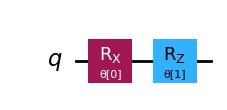

In [2]:
# define hamiltonian (Y) by hand
"""
# Define Pauli matrices
#op0 = np.array([[1.0, 0.0], [0, 0]], dtype=complex)
#op3 = np.array([[0.0, 0.0], [0, -1]], dtype=complex)
Id = np.array([[1.0, 0], [0, 1]], dtype=complex)
X = np.array([[0.0, 1], [1, 0]], dtype=complex)
Y = np.array([[0.0, -1j], [1j, 0]], dtype=complex)
Z = np.array([[1.0, 0], [0, -1]], dtype=complex)
#
g0 = 0.2252; g1 = 0.3435; g2 = -0.4347; g3= 0.5716; g4 = 0.0910; g5 = 0.0910;
hamiltonian = g0*np.kron(Id,Id) + g1*np.kron(Z,Id) + g2*np.kron(Id,Z) + g3*np.kron(Z,Z) + g4*np.kron(Y,Y) + g5*np.kron(X,X)
"""

hamiltonian = SparsePauliOp(["Y"], coeffs=[1.0])
ansatz = EfficientSU2(hamiltonian.num_qubits,  su2_gates=['rx', 'rz'], reps=0)
ansatz.decompose().draw("mpl")

In [5]:
tdim = 1200

"""
# scipy - has the disadvantage of not returning the angle parameters along the evolution, only the final state
#### assign initial state
init_state = Statevector(ansatz.assign_parameters(init_param_values))
#### evolve exactly with scipy
evolution_problem = TimeEvolutionProblem(
    hamiltonian, time, initial_state=init_state, aux_operators=aux_ops
)
exact_evol = SciPyRealEvolver(num_timesteps=tdim)
sol = exact_evol.evolve(evolution_problem)
#
exact_h_exp_val = sol.observables[0][0].real
"""

# VarQRTE
#### initial ansatz parameters
init_param_values = {}
init_param_values[ansatz.parameters[0]] = 0.1734
init_param_values[ansatz.parameters[1]] = 0.3909
#### define VarQITE
var_principle = RealMcLachlanPrinciple()
#### time evolution problem
time = 4.0
aux_ops = [hamiltonian]
#
evolution_problem = TimeEvolutionProblem(hamiltonian, time, aux_operators=aux_ops) #
#### evolve with VarQITE >>>> takes some time
var_qrte = VarQRTE(ansatz, init_param_values, variational_principle=var_principle, estimator=Estimator(), num_timesteps=tdim)
evolution_result = var_qrte.evolve(evolution_problem)
# save results to arrays
h_exp_val = np.array([ele[0][0] for ele in evolution_result.observables])
times = evolution_result.times

In [6]:
# get wavefunction according to ansatz
def getPsi(thx,thz):
    return np.array([ exp(-1j*thz/2) * cos(thx/2), -1j * exp(1j*thz/2) * sin(thx/2) ])

# analytical solution to "wrong" VarQRTE evolution following eq 12 (see Mathematica notebook)
def getThetaWrong(t):
    th0x = 0.1734
    th0z = 0.3909
    return th0x + t * 2*sin(th0z) + 0*1j, th0z + t*0 + 0*1j

# get wavefunctions in time according to equations 12 (Wrong) and 35 (Corr)
psiCorr = getPsi(evolution_result.parameter_values[:,0], evolution_result.parameter_values[:,1])
thetaWrong = np.array(getThetaWrong(times))
psiWrong = getPsi(thetaWrong[0,:], thetaWrong[1,:])

# compute fidelity
Fidelitylst = np.array( [ np.abs(np.vdot(psiWrong[:,i], psiCorr[:,i]))**2 for i in range(len(times))] )

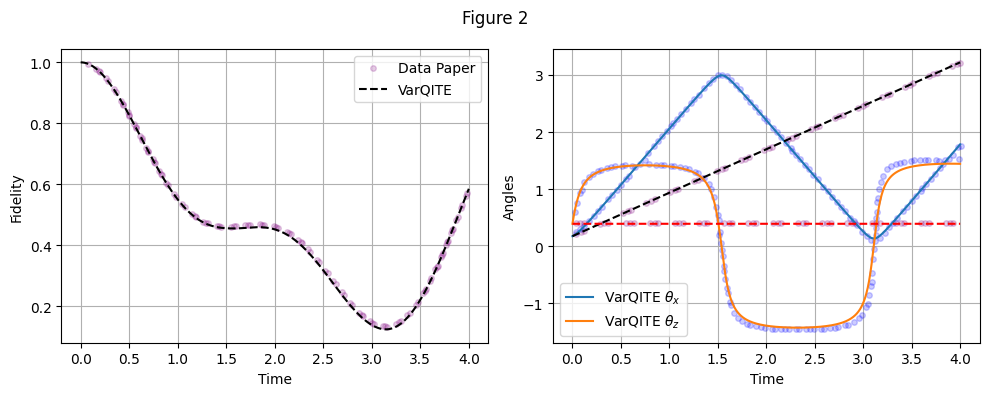

In [12]:
# fluctuations in the dataWPD will be due to uncertainty in selecting points in WPD
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
alphaWPD = 0.2

### fig 2 - main
f = open('dataWPD/fig2_main/wpd.json')
data = json.load(f)
# 
datatmp = data['datasetColl'][0]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
axes[0].plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'o', color='purple', markersize=4, alpha=alphaWPD, label=r'Data Paper')

### fig 2 - in
f = open('dataWPD/fig2_in/wpd.json')
data = json.load(f)
# 
datatmp = data['datasetColl'][0]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
axes[1].plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'o', color='purple', markersize=4, alpha=alphaWPD)
# 
datatmp = data['datasetColl'][1]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
axes[1].plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'o', color='blue', markersize=4, alpha=alphaWPD)

## plot simulation results
axes[1].plot(times, evolution_result.parameter_values[:,0], label=r'VarQITE $\theta_x$')
axes[1].plot(times, evolution_result.parameter_values[:,1], label=r'VarQITE $\theta_z$')

axes[0].plot(times, Fidelitylst, 'k--', label="VarQITE")

# "wrong" evolution according to equation 12
axes[1].plot(times, thetaWrong[0,:], 'k--')
axes[1].plot(times, thetaWrong[1,:], 'r--')

axes[0].set_xlabel(r'Time')
axes[1].set_xlabel(r'Time')
axes[0].set_ylabel(r'Fidelity')
axes[1].set_ylabel(r'Angles')
axes[0].legend()
axes[1].legend()
axes[0].grid()
axes[1].grid()
plt.suptitle(r'Figure 2')
plt.tight_layout()
#plt.savefig('fig2_dataWPD.pdf', transparent=True)
plt.show()

### Figure 5

In [13]:
# Figure 5: ... still need to apply QuTIP for variational part

# Define Pauli matrices and ops
op0 = np.array([[1.0, 0.0], [0, 0]], dtype=complex)
op3 = np.array([[0.0, 0.0], [0, -1]], dtype=complex)
opm = np.array([[0.0, 1.0], [0, 0]], dtype=complex) #+
opp = np.array([[0.0, 0.0], [1.0, 0]], dtype=complex) #-
Id = np.array([[1.0, 0], [0, 1]], dtype=complex)
X = np.array([[0.0, 1], [1, 0]], dtype=complex)
Y = np.array([[0.0, -1j], [1j, 0]], dtype=complex)
Z = np.array([[1.0, 0], [0, -1]], dtype=complex)
#

H = np.kron(X,Id) + np.kron(Id,X) + 0.25*np.kron(Z,Z)
def drhodt(rho):
    L1 = 0.5*( 2*np.kron(opm,Id) @ rho @ np.kron(opp,Id) - np.kron(opp,Id) @ np.kron(opm,Id) @ rho - rho @ np.kron(opp,Id) @ np.kron(opm,Id) )
    L2 = 0.5*( 2*np.kron(Id,opm) @ rho @ np.kron(Id,opp) - np.kron(Id,opp) @ np.kron(Id,opm) @ rho - rho @ np.kron(Id,opp) @ np.kron(Id,opm) )
    return -1j*(H@rho-rho@H) + L1 + L2

rho0 = np.zeros((4,4), dtype=complex)
rho0[0,0] = 1.0
rho = np.copy(rho0)
tmax = 10.0
tdim = int(tmax/0.01)
dt = tmax/tdim
tlst = np.linspace(0,tmax,tdim)
Z0avg = np.zeros(tdim, dtype=complex)

for i in range(tdim):
    Z0avg[i] = np.trace(np.kron(Z,Id) @ rho)
    rho = rho + dt * drhodt(rho)

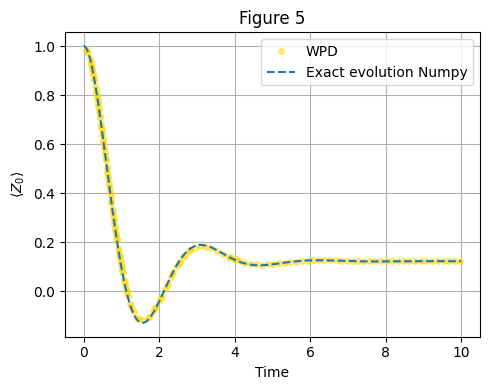

In [15]:
### fig 5
# fluctuations in the dataWPD will be due to uncertainty in selecting points in WPD
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,4))

f = open('dataWPD/fig5/wpd.json')
data = json.load(f)
# 
datatmp = data['datasetColl'][0]['data']
datatmp2 = np.array([datatmp[i]['value'] for i in range(len(datatmp))])
indxs = np.argsort(datatmp2[:,0])
plt.plot(datatmp2[:,0][indxs],datatmp2[:,1][indxs],'o', color='gold', markersize=4, alpha=0.5, label='WPD')

plt.plot(tlst, np.real(Z0avg), '--', label='Exact evolution Numpy')

plt.title(r"Figure 5")
plt.xlabel(r'Time')
plt.ylabel(r'$\langle Z_0 \rangle$')
plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig('fig2_dataWPD.pdf', transparent=True)
plt.show()